# Simple NN


In [1]:
import sys
# sys.path.append("/home/arseni1919/PycharmProjects/NT_sandbox")
sys.path.append("/Users/arseniperchik/PycharmProjects/NT_sandbox")

print(sys.path)
from IMPORTS import *

%matplotlib inline
%config Completer.use_jedi = False
# print(sys.path)

['/Users/arseniperchik/PycharmProjects/NT_sandbox/NN', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python37.zip', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/lib-dynload', '', '/Users/arseniperchik/.local/lib/python3.7/site-packages', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/site-packages', '/Users/arseniperchik/PycharmProjects/gym-stocktrading', '/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/site-packages/IPython/extensions', '/Users/arseniperchik/.ipython', '/Users/arseniperchik/PycharmProjects/NT_sandbox']


# Some Function - *y_func*

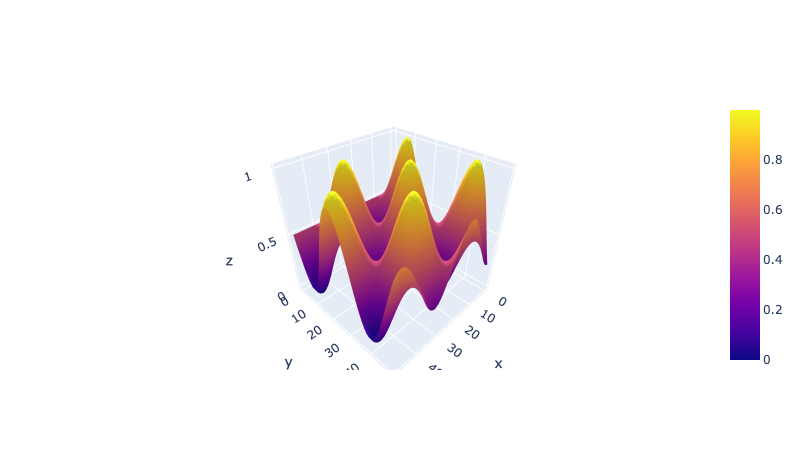

In [13]:
def y_func(a, b):
    """
    :param a: between [0, 1]
    :param b: between [0, 1]
    :return: between [0, 1]
    """
    mult = 50
    a *= mult
    b *= mult
    return np.sin(a / 5) * np.cos(b / 5) / 2 + 0.5  # - np.log(b)


def compare_graphs(func_hat, func_real, compare: bool =True):
    x = np.linspace(0.0, SCALE, num=50)
    y = np.linspace(0.0, SCALE, num=50)
    z_hat = np.zeros((len(x), len(y)))
    z_real = np.zeros((len(x), len(y)))
    scatter_dict_real = {'x': [], 'y': [], 'z': []}
    scatter_dict_hat = {'x': [], 'y': [], 'z': []}

    for i_indx, i in enumerate(x):
        for j_indx, j in enumerate(y):
            z_hat[i_indx, j_indx] = func_hat(torch.Tensor([[i, j]]).double()).item()
            z_real[i_indx, j_indx] = func_real(i, j)
            x_rund_num = random.uniform(0, SCALE)
            y_rund_num = random.uniform(0, SCALE)
            scatter_dict_real['x'].append(x_rund_num)
            scatter_dict_real['y'].append(y_rund_num)
            scatter_dict_real['z'].append(func_real(x_rund_num, y_rund_num))
            if compare:
                scatter_dict_hat['x'].append(x_rund_num)
                scatter_dict_hat['y'].append(y_rund_num)
                scatter_dict_hat['z'].append(
                    func_hat(torch.Tensor([[x_rund_num, y_rund_num]]).double()).item()
                )

    if compare:
        fig = go.Figure(data=[
            go.Surface(z=z_hat),
            go.Surface(z=z_real, opacity=0.5)
        ])# showscale=False, colorbar_x=-0.07,
        fig.show()
    else:
        fig = go.Figure(data=[
#             go.Surface(z=z_hat),
            go.Surface(z=z_real, opacity=1)
        ])# showscale=False, colorbar_x=-0.07,
        fig.show()
#         fig = px.scatter_3d(scatter_dict_real,
#                             x='x', y='y', z='z', opacity=0.1, color='z', size_max=5)
#         fig.show()

compare_graphs(func_hat=lambda x, y=0 : torch.Tensor([0]), func_real=y_func, compare=False)

## I - Dataset 

In [3]:
class ALGDataset(Dataset):
    def __init__(self, func):
        self.func = func
        self.buffer = deque(maxlen=REPLAY_SIZE)
        for i in range(REPLAY_SIZE):
            x_num = random.uniform(0, SCALE)
            y_num = random.uniform(0, SCALE)
            z_num = self.func(x_num, y_num)
            obs_xy = torch.Tensor([x_num, y_num]).double()
            obs = (obs_xy, z_num)
            self.buffer.append(obs)

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, indx):
        z_num = self.buffer[indx]
        return z_num

    def append(self, new_z):
        self.buffer.append(new_z)


alg_dataset = ALGDataset(y_func)


## II - LightningDataModule

In [4]:
class ALGDataModule(pl.LightningDataModule):

    def __init__(self, alg_dataset):
        super().__init__()
        self.alg_dataset = alg_dataset

    def setup(self, stage=None):
        pass

    def train_dataloader(self):
        return DataLoader(self.alg_dataset, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        pass

    def test_dataloader(self):
        pass


alg_data_module = ALGDataModule(alg_dataset)

In [106]:
# for batch in data_module.train_dataloader():
#     print(batch)

## CallBacks

In [7]:
class ALGCallback(Callback):

    def on_init_start(self, trainer):
        print('--- Starting to init trainer! ---')

    def on_init_end(self, trainer):
        print('--- trainer is init now ---')

    def on_train_end(self, trainer, pl_module):
        # print('--- training ends ---')
        torch.save(pl_module.state_dict(), "example.ckpt")

    def on_train_epoch_end(self, trainer, pl_module, outputs):
        """Called when the train epoch ends."""
        pass

    def on_train_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx):
        # print('--- print batch ---')
        # for i in batch:
        #     print(i)
        pass

## III - ALGLightningModule

In [5]:
class ALGLightningModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),

        )
        self.net.double()
        self.counter = 0

    def forward(self, x):
        x = self.net(x)
        return x

    def training_step(self, batch, batch_idx):

        x, y = batch
        y_hat = self(x)
        y_hat = y_hat.view(-1)
        loss = F.mse_loss(y_hat, y)  # F.mse_loss(y_hat, y.float())

        self.log('train loss', loss)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)


alg_lit_module = ALGLightningModule()

psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/1919ars/NA-sandbox/e/NAS-14


NeptuneLogger will work in online mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

you passed in a val_dataloader but have no validation_step. Skipping validation loop



--- Starting to init trainer! ---
--- trainer is init now ---



  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 33 K  
/Users/arseniperchik/opt/anaconda3/envs/DRL4/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



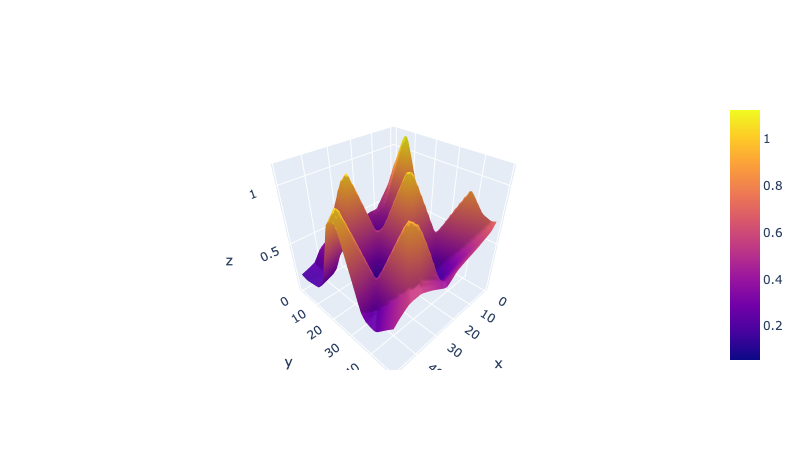

In [8]:
trainer = pl.Trainer(logger=NeptuneLogger(project_name="1919ars/NA-sandbox"),
                         max_epochs=10,
                         callbacks=[ALGCallback()])
trainer.fit(model=alg_lit_module, datamodule=alg_data_module)

# --- comparison to real function ---
model = ALGLightningModule()
model.load_state_dict(torch.load("example.ckpt"))
compare_graphs(model, y_func)

## Real Function And It's Prediction By The Model

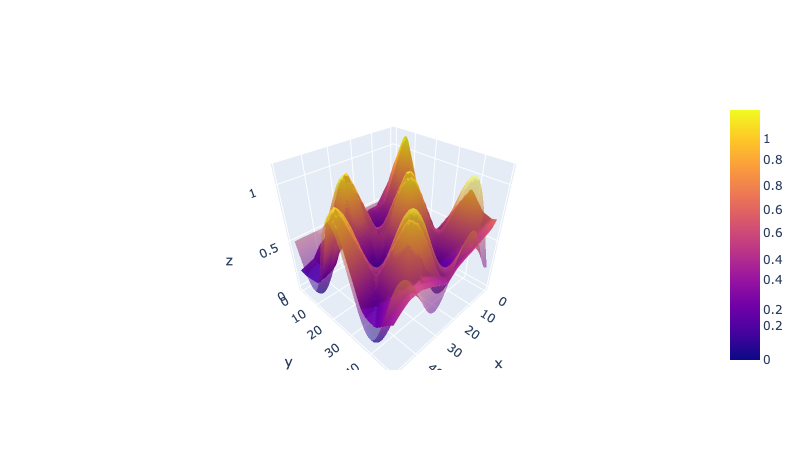

In [11]:
compare_graphs(model, y_func)